In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats.stats import pearsonr

from operator import itemgetter
from collections import defaultdict
import json
%matplotlib inline

In [2]:
#Itemgetter is used to iterate over a list of lists
#defaultdict is used when a key,value pair may or may not exist
#json(standardized object notation , data with hierarchies)

In [3]:
restaurantDataFrame=pd.read_csv('bigdf.csv',index_col=0)
# restaurantDataFrame.head()
# restaurantDataFrame.info()
restaurantDataFrame=restaurantDataFrame[['user_id','user_name','business_id','biz_name','stars']]

In [4]:
#This has been refactored into a function below
# user_avg=restaurantDataFrame[['user_id','stars']].groupby('user_id').mean()
# restaurantDataFrame.set_index('user_id',inplace=True)
# restaurantDataFrame['user_avg']=user_avg
# restaurantDataFrame.reset_index(inplace=True)
# print restaurantDataFrame.head(2)

# bus_avg=restaurantDataFrame[['business_id','stars']].groupby('business_id').mean()
# restaurantDataFrame.set_index('business_id',inplace=True)
# restaurantDataFrame['bus_avg']=bus_avg
# restaurantDataFrame.reset_index(inplace=True)
# print restaurantDataFrame.head(2)

In [5]:
def GetAverage(restdata):
    user_avg=restdata[['user_id','stars']].groupby('user_id').mean()
    restdata.set_index('user_id',inplace=True)
    restdata['user_avg']=user_avg
    restdata.reset_index(inplace=True)
    
    bus_avg=restdata[['business_id','stars']].groupby('business_id').mean()
    restdata.set_index('business_id',inplace=True)
    restdata['business_avg']=bus_avg
    restdata.reset_index(inplace=True)
    
    return restdata

In [6]:
def GetCount(restdata):
    user_count=restdata[['user_id','stars']].groupby('user_id').count()
    restdata.set_index('user_id',inplace=True)
    restdata['user_count']=user_count
    restdata.reset_index(inplace=True)
    
    bus_count=restdata[['business_id','stars']].groupby('business_id').count()
    restdata.set_index('business_id',inplace=True)
    restdata['business_count']=bus_count
    restdata.reset_index(inplace=True)
    
    return restdata

In [7]:
#Get all rows where user has more than 20 reviews and businesses have more than 80 reviews
restaurantDataFrame=GetAverage(restaurantDataFrame)
restaurantDataFrame=GetCount(restaurantDataFrame)
restaurantReducedDataFrame=restaurantDataFrame.ix[(restaurantDataFrame.user_count >= 20) &   (restaurantDataFrame.business_count >=80)]


In [8]:
#Assignment 
#Generate user review count, dataframe with userid and count,build histogram
#Repeat for businesses

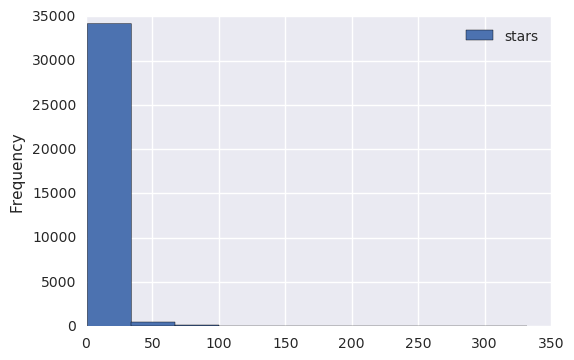

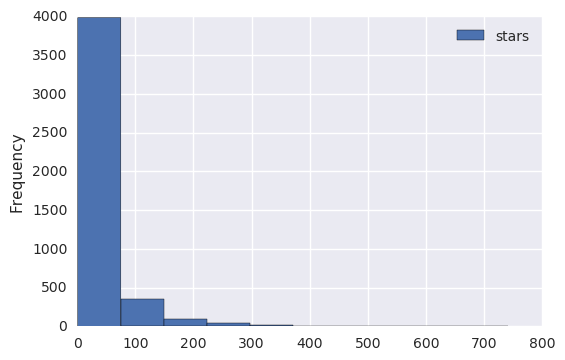

In [9]:
restaurantDataFrame[['user_id','stars']].groupby('user_id').count().plot(kind='hist')
restaurantDataFrame[['business_id','stars']].groupby('business_id').count().plot(kind='hist')

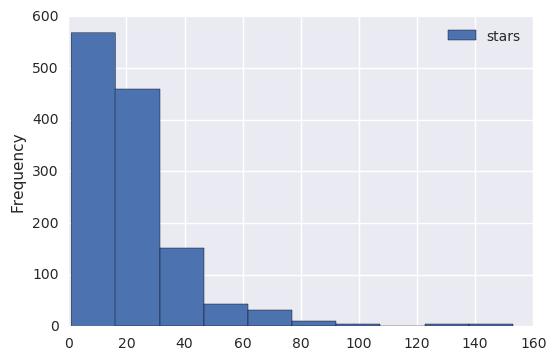

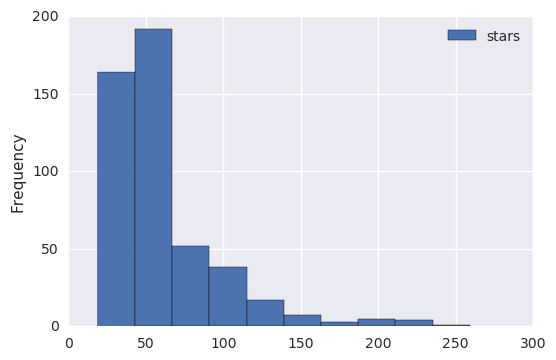

In [10]:
restaurantReducedDataFrame[['user_id','stars']].groupby('user_id').count().plot(kind='hist')
restaurantReducedDataFrame[['business_id','stars']].groupby('business_id').count().plot(kind='hist')

In [11]:
# Because the user counts and business counts still taper off on the reduced dataframe we will try to filter it further
restaurantReducedDataFrame=restaurantDataFrame.ix[(restaurantDataFrame.user_count >= 60) &   (restaurantDataFrame.business_count >=150)]


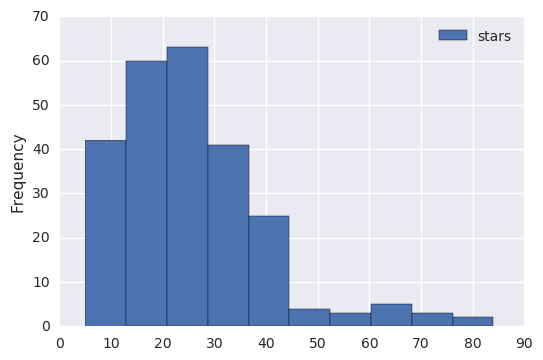

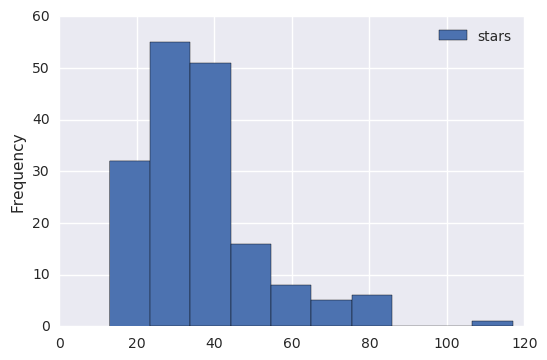

In [12]:
restaurantReducedDataFrame[['user_id','stars']].groupby('user_id').count().plot(kind='hist')
restaurantReducedDataFrame[['business_id','stars']].groupby('business_id').count().plot(kind='hist')

In [13]:
# Create a func to identify list of restaurants reviewed by each user
#Create a fun to compare the list of restaurnats and return common restaurants for each pair of users

In [14]:
def GetSupport(dataframe):
    supportdataframe=pd.DataFrame({
            'user1':[],
            'user2':[],
            'commonrestaurants':[],
            'support':[]
            })
#     mylist=[]
    for user1 in dataframe.user_id.unique():
        for user2 in dataframe.user_id.unique():
            if user1 != user2:
                user1df=dataframe[dataframe.user_id==user1]
                user2df=dataframe[dataframe.user_id==user2]
                commonrestaurants=set(user1df.business_id.values).intersection(set(user2df.business_id.values))
#                 mylist.append([user1,user2,commonrestaurants])
                supportdataframe=supportdataframe.append(
                    pd.Series({
                            'user1':user1,
                            'user2':user2,
                            'commonrestaurants':commonrestaurants,
                            'support':len(commonrestaurants),
                        }),ignore_index=True)
    return supportdataframe

In [15]:
import time
starttime=time.time()
supportdataframe=GetSupport(restaurantReducedDataFrame)
print('total time -mins',(time.time() - starttime)/60)

('total time -mins', 9.519864082336426)


In [16]:
supportdataframe.head(2)

,commonrestaurants,support,user1,user2
0,"{pwpl-rxwNRQdgqFz_-qMPg, Zx8_4zKdDBSO3qGrkukBI...",10.0,rLtl8ZkDX5vH5nAx9C3q5Q,C6IOtaaYdLIT5fWd7ZYIuA
1,"{rZbHg4ACfN3iShdsT47WKQ, L9UYbtAUOcfTgZFimehlX...",6.0,rLtl8ZkDX5vH5nAx9C3q5Q,mlBC3pN9GXlUUfQi1qBBZA


In [17]:
def GetPearsonValue(supportdataframe,dataframe):
    pearsoncoeff=[]
    for row in supportdataframe.index:
        user1=supportdataframe.ix[row].user1
        user2=supportdataframe.ix[row].user2
        commonrestaurants=supportdataframe.ix[row].commonrestaurants
        user1df=restaurantReducedDataFrame[restaurantReducedDataFrame.user_id==user1][['business_id','stars']]
        user2df=restaurantReducedDataFrame[restaurantReducedDataFrame.user_id==user2][['business_id','stars']]
        user1df=user1df.set_index('business_id')
        user2df=user2df.set_index('business_id')
        user1df=user1df['stars']-user1df['stars'].mean()
        user2df=user2df['stars']-user2df['stars'].mean()
        user1df=user1df[user1df.index.isin(commonrestaurants)]
        user2df=user2df[user2df.index.isin(commonrestaurants)]
        user1df=user1df.sort_index()
        user2df=user2df.sort_index()
        pearsoncoeff.append(pearsonr(user1df,user2df)[0])
    supportdataframe['pearsoncoeff']=pearsoncoeff
    return supportdataframe

In [18]:
import time
starttime=time.time()
newsupportdataframe=GetPearsonValue(supportdataframe,restaurantReducedDataFrame)
print('total time -mins',(time.time() - starttime)/60)

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


('total time -mins', 6.862800864378611)


In [19]:
newsupportdataframe.head(2)

,commonrestaurants,support,user1,user2,pearsoncoeff
0,"{pwpl-rxwNRQdgqFz_-qMPg, Zx8_4zKdDBSO3qGrkukBI...",10.0,rLtl8ZkDX5vH5nAx9C3q5Q,C6IOtaaYdLIT5fWd7ZYIuA,0.184428
1,"{rZbHg4ACfN3iShdsT47WKQ, L9UYbtAUOcfTgZFimehlX...",6.0,rLtl8ZkDX5vH5nAx9C3q5Q,mlBC3pN9GXlUUfQi1qBBZA,-0.428746


In [20]:
#Goal is to create a dtaframe where we sort user2 for every user 1, After that pick up the restaurants for those user 
# 2s. These distinct restaurant ids should be the rows and columns should be the top 5 user 2s
# Then retrieve the rating for each restaurant by that user and update it in the new dataframe

In [21]:
# def GetRating(dataframe):
#     similarusers=dataframe.sort_values('pearsoncoeff',ascending=False).head()
# #     Get Restuarants rated by the similar users
#     user2df=restaurantReducedDataFrame[restaurantReducedDataFrame.user_id.isin(similarusers.user2)]
#     restaurants=user2df.business_id.unique()
#     user2dict={user:[0]*len(restaurants) for user in similarusers.user2}
#     restaurantdf=pd.DataFrame(user2dict,index=restaurants)
#     for row in user2df.index:
#         user=user2df.ix[row,'user_id']
#         restaurant=user2df.ix[row,'business_id']
#         restaurantdf.ix[restaurant,user]=user2df.ix[row,'stars'] -user2df.ix[row,'user_avg']
#     return restaurantdf
# newsupportdataframe.groupby('user1').apply(GetRating)

In [148]:
def GetSmallerSupport(supportdf):
    df=supportdf.copy()
    df['normalized_sim']=df['pearsoncoeff']*df['support']/(df['support']+3)
    df=df.sort_values('normalized_sim',ascending=False).head()
    return df
smallersupportdf=newsupportdataframe.groupby('user1').apply(GetSmallerSupport).drop('user1',axis=1).reset_index()

In [159]:
def GetSomething(dataframe):    
    alluser2Restaurants=restaurantReducedDataFrame[restaurantReducedDataFrame.user_id.isin(dataframe.user2.values)]['business_id'].values
    user1=dataframe.user1.values[0]
    alluser1Restuarants=restaurantReducedDataFrame[restaurantReducedDataFrame.user_id==user1].business_id.values
    allnewuser1Rest=[eachrest for eachrest in alluser2Restaurants if eachrest not in alluser1Restuarants]
    restrating={}
    for rest in allnewuser1Rest:
        restdf=restaurantReducedDataFrame[restaurantReducedDataFrame.business_id==rest]
        restdf=restdf[restdf.user_id.isin(dataframe.user2.values)].set_index('user_id')
        restdfwsim=restdf.join(dataframe.set_index('user2'))
        restdfwsim['newrating']=restdfwsim['stars']*restdfwsim['pearsoncoeff']
        restrating[rest]=restdfwsim['newrating'].mean()
    return sorted(restrating.items(),key=itemgetter(1),reverse=True)

In [160]:
smallersupportdf.groupby('user1').apply(GetSomething)

user1
--65q1FpAL_UQtVZ2PTGew    [(vARjqeIkSNsazHltujiq4Q, 5.0), (L9UYbtAUOcfTg...
-9mljS0O9mwdOnGv-Oea3Q    [(oXKPSI-RUqOvmuSCh_DEQQ, 5.0), (KPoTixdjoJxSq...
-F32Vl8Rk4dwsmk0f2wRIw    [(DcrM4hwDcU2G6vuh2cnaYQ, 4.63586324973), (zp7...
04xW5mhSBaCzpjbcf2VSZg    [(rZbHg4ACfN3iShdsT47WKQ, 5.0), (PmPOuRvuN3CoN...
0bNXP9quoJEgyVZu9ipGgQ    [(rDvz5jX65gpfONFu7er9Tw, 4.49358517136), (Lzp...
0o0VMEJeQY0pAAZ9nxErBA    [(rZbHg4ACfN3iShdsT47WKQ, 5.0), (8t80-omyflkyw...
0oRtnPHtvZIE1UNxCDDTPw    [(uEJQSIjWui-TDWXaGlcqyQ, 4.71404520791), (QnA...
0qIsBt4EzBDCKrIviV55Ew    [(YQvg0JCGRFUkb6reMMf3Iw, 5.0), (5VMajxduxfLPS...
100Df1wcVrl9rJgB7EG6xw    [(VVeogjZya58oiTxK7qUjAQ, 5.0), (cLojUtqkFpVIH...
17PPxx8RxjOUD_nQZ1aHEw    [(IuAPYzf3NSyfyXYgT46YVA, 5.0), (rQ4z0EStSZE4a...
1BW2HC851fJKPfJeQxjkTA    [(SMpL3z4FLF07bRA6-y22JQ, 5.0), (FURgKkRFtMK5y...
33vUIil_GCaT92aUaZhRXA    [(2ceeU8e3nZjaPfGmLwh4kg, 4.81125224325), (7cP...
3Jw-rYwJEz6jSqPgVVmmhA    [(qjmCVYkwP-HDa35jwYucbQ, 4.52267016867), (L9U...
3ONPPa

In [ ]:
User2 Restaurants not visited by User 1
For each restaurant , find dataset and filter to only reviews by top 5 user2s
In that dataset modify the review rating based on similarity
Then take the average and return
